# Import Required Libraries
Import the necessary libraries, including pandas, numpy, and matplotlib.

In [1]:
import sys
print(sys.executable)

/usr/local/python/3.12.1/bin/python3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data from Excel Files
Load the data from the six Excel files using pandas, specifying the correct sheet and cell ranges.

In [3]:
# Load Data from Excel Files

# List of file paths for the Excel files
file_paths = [
    '110.xlsx',
    '140.xlsx',
    '155.xlsx',
    '160.xlsx',
    '170.xlsx',
    '175.xlsx'
]

# Initialize lists to store data from each file
accelerator_voltage_data = []
collector_current_data = []
time_data = []

# Function to convert millivolt values to volt
def convert_to_volts(value):
    try:
        if isinstance(value, str):
            if value.endswith('m'):
                return float(value[:-1]) / 1000
            elif value.endswith('u'):
                return float(value[:-1]) / 1_000_000
        return float(value)
    except ValueError:
        return np.nan  # Return NaN for invalid strings

# Loop through each file and load the data
for file_path in file_paths:
    # Read the Excel file
    df = pd.read_excel(file_path, sheet_name=0, usecols="B:E", skiprows=10)
    
    # Convert values with 'm' to volts
    df = df.applymap(convert_to_volts)
    
    # Append the data to the respective lists
    time_data.append(df.iloc[:, 0].values)
    accelerator_voltage_data.append(df.iloc[:, 2].values)
    collector_current_data.append(df.iloc[:, 3].values)

# Convert lists to numpy arrays for easier manipulation
time_data = np.array(time_data)
accelerator_voltage_data = np.array(accelerator_voltage_data)
collector_current_data = np.array(collector_current_data)

/tmp/ipykernel_725/3425522713.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_volts)
/tmp/ipykernel_725/3425522713.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_volts)
/tmp/ipykernel_725/3425522713.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_volts)
/tmp/ipykernel_725/3425522713.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_volts)
/tmp/ipykernel_725/3425522713.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_volts)
/tmp/ipykernel_725/3425522713.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(convert_to_volts)


In [4]:
accelerator_voltage_data
# print its size
print(accelerator_voltage_data.shape)

(6, 4000)


# Preprocess Data
Clean and preprocess the data, including handling missing values and converting data types if necessary.

In [5]:
# Preprocess Data

# Function to apply moving average smoothing
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Handle missing values by filling them with the mean of the respective columns
for i in range(len(file_paths)):
    time_data[i] = np.where(np.isnan(time_data[i]), np.nanmean(time_data[i]), time_data[i])
    accelerator_voltage_data[i] = np.where(np.isnan(accelerator_voltage_data[i]), np.nanmean(accelerator_voltage_data[i]), accelerator_voltage_data[i])
    collector_current_data[i] = np.where(np.isnan(collector_current_data[i]), np.nanmean(collector_current_data[i]), collector_current_data[i])

    # Apply moving average smoothing
    smoothed_time_data = moving_average(time_data[i])
    smoothed_accelerator_voltage_data = moving_average(accelerator_voltage_data[i])
    smoothed_collector_current_data = moving_average(collector_current_data[i])

    # Shift values to start from zero
    time_data[i] = time_data[i] - np.min(time_data[i])
    accelerator_voltage_data[i] = accelerator_voltage_data[i] - np.min(accelerator_voltage_data[i])
    collector_current_data[i] = collector_current_data[i] - np.min(collector_current_data[i])
    
# Convert data types if necessary (ensure all data is in float format)
time_data = time_data.astype(float)
accelerator_voltage_data = accelerator_voltage_data.astype(float)
collector_current_data = collector_current_data.astype(float)

# Plot Data
Plot the accelerator voltage against the collector current for each temperature to visualize the data.

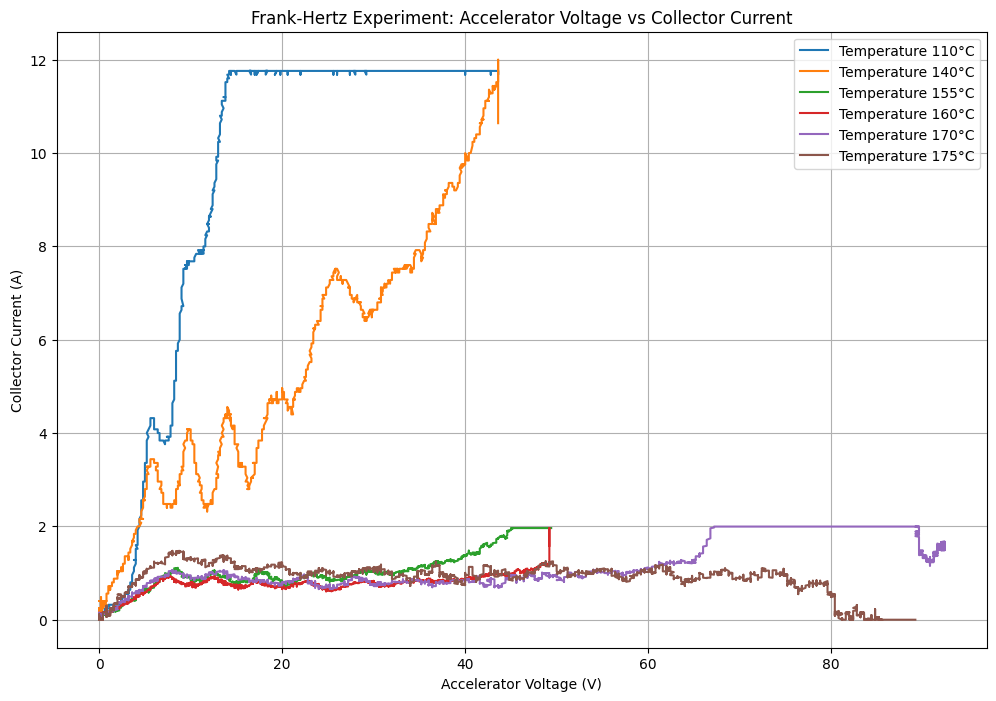

In [6]:
# Plot Data

# Plot the accelerator voltage against the collector current for each temperature
plt.figure(figsize=(12, 8))

# Loop through each dataset and plot
for i in range(len(file_paths)):
    plt.plot(accelerator_voltage_data[i], collector_current_data[i], label=f'Temperature {file_paths[i].split(".")[0]}°C')

# Add labels and title
plt.xlabel('Accelerator Voltage (V)')
plt.ylabel('Collector Current (A)')
plt.title('Frank-Hertz Experiment: Accelerator Voltage vs Collector Current')
plt.legend()
plt.grid(True)
plt.show()

# Identify Current Dips
Implement a method to identify the dips in the collector current and mark them on the plots.

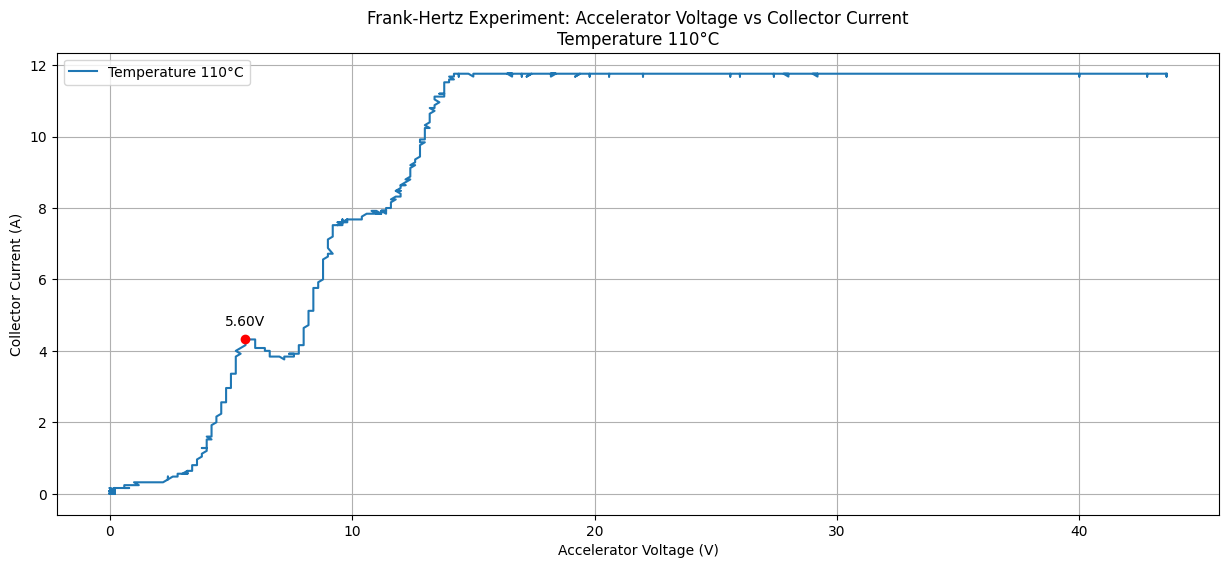

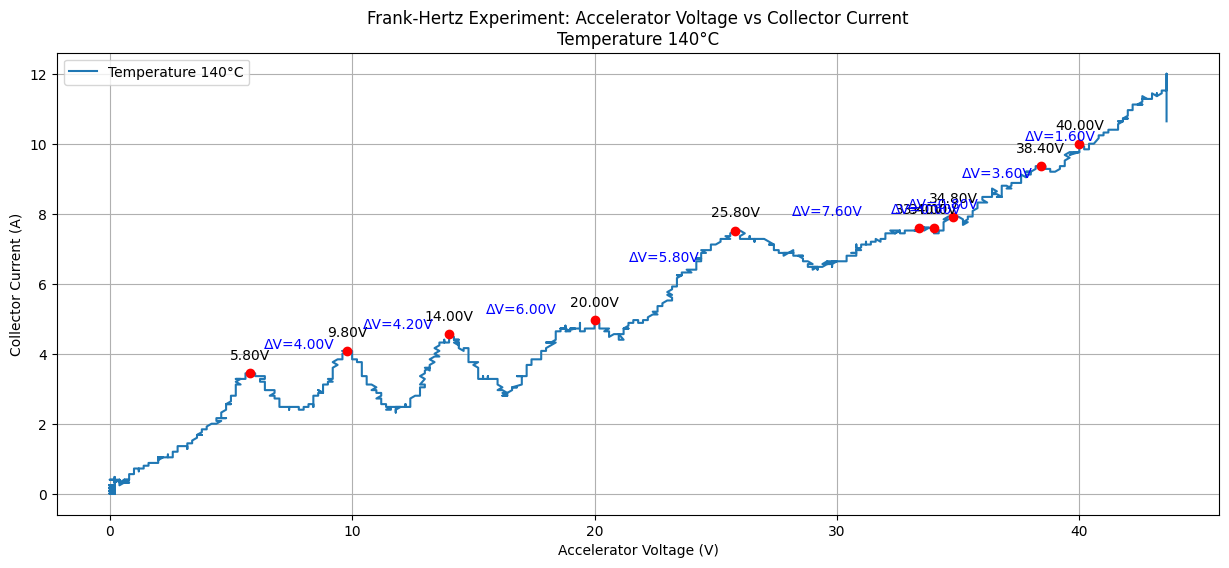

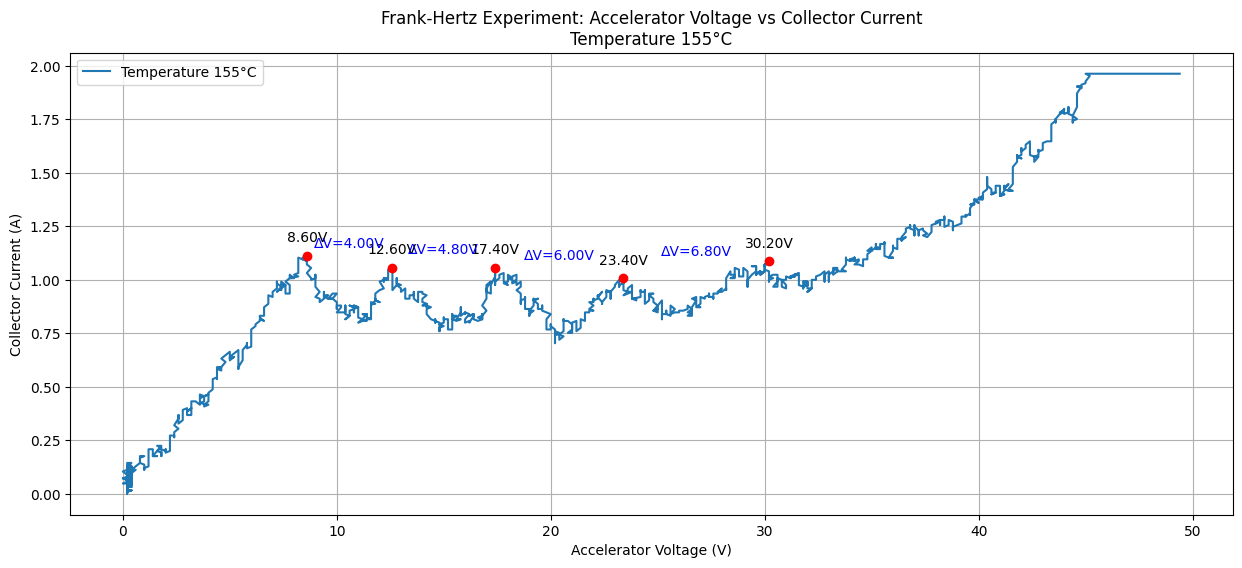

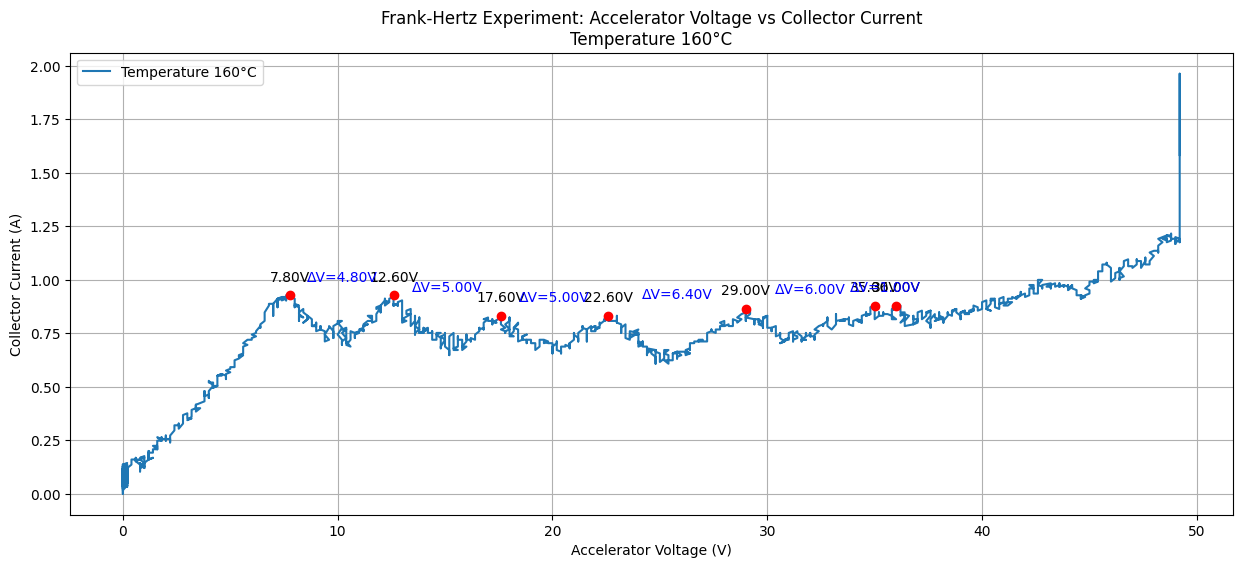

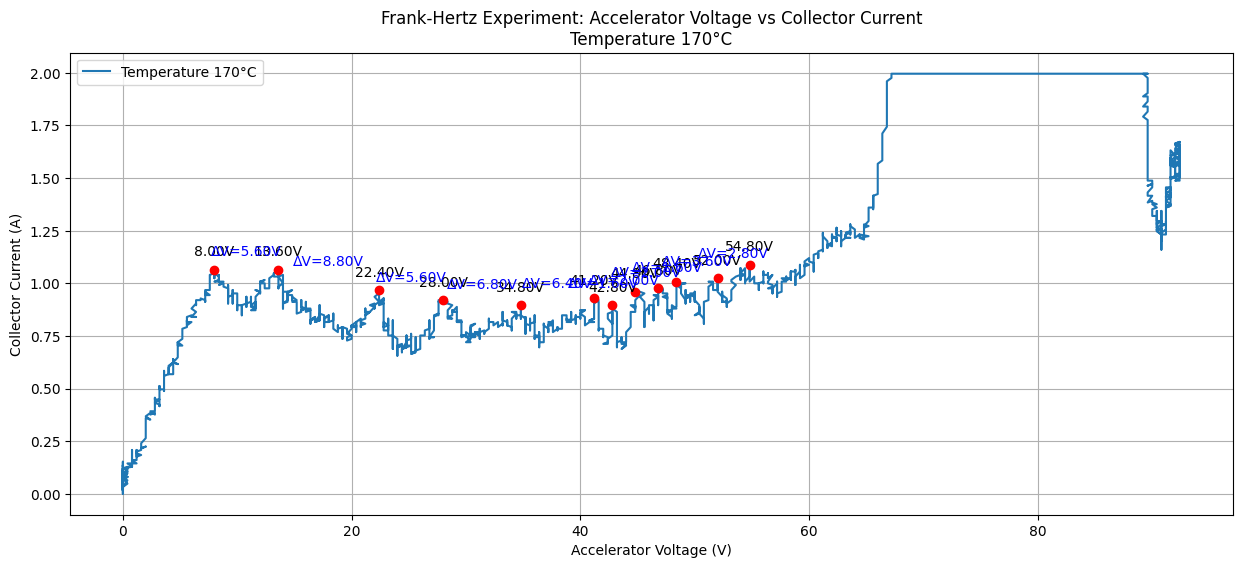

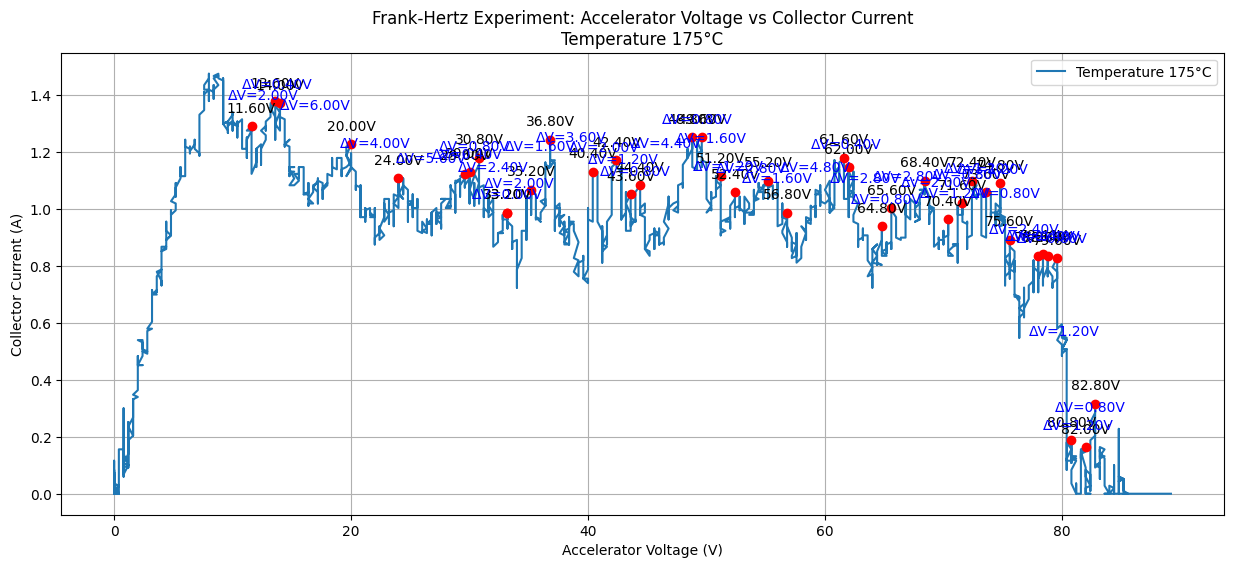

In [7]:
import scipy.signal

# Identify Current Dips

# Function to identify dips in the collector current
def identify_current_dips(voltage, current, distance=10, prominence=0.1, width=5, exclude_ends=800):
    # Exclude a certain number of points from the start and end
    voltage = voltage[exclude_ends:-exclude_ends]
    current = current[exclude_ends:-exclude_ends]
    
    # Use scipy.signal.find_peaks to find peaks in the negative of the current (dips)
    dips, _ = scipy.signal.find_peaks(current, distance=distance, prominence=prominence, width=width)
    
    # Adjust dips indices to account for the excluded points
    dips += exclude_ends
    
    return dips


# Plot Data with Dips Marked


# Loop through each dataset and plot
for i in range(len(file_paths)):
    voltage = accelerator_voltage_data[i]
    current = collector_current_data[i]
    
    # Identify dips
    dips = identify_current_dips(voltage, current)
    
    # Plot the accelerator voltage against the collector current for each temperature
    plt.figure(figsize=(15, 6))

    # Plot the data
    plt.plot(voltage, current, label=f'Temperature {file_paths[i].split(".")[0]}°C')  # Plot the data
    
    # Mark the dips
    plt.plot(voltage[dips], current[dips], 'ro')  # Red circles for dips

    # Annotate each dip with its voltage point
    for dip in dips:
        plt.annotate(f'{voltage[dip]:.2f}V', (voltage[dip], current[dip]), textcoords="offset points", xytext=(0,10), ha='center')

    # Annotate deltaV between each set of dips
    for j in range(len(dips) - 1):
        deltaV = voltage[dips[j + 1]] - voltage[dips[j]]
        mid_point = (voltage[dips[j]] + voltage[dips[j + 1]]) / 2
        plt.annotate(f'ΔV={deltaV:.2f}V', (mid_point, (current[dips[j]] + current[dips[j + 1]]) / 2), textcoords="offset points", xytext=(0,10), ha='center', color='blue')
    
    # Add labels and title
    plt.xlabel('Accelerator Voltage (V)')
    plt.ylabel('Collector Current (A)')
    plt.title(f'Frank-Hertz Experiment: Accelerator Voltage vs Collector Current\nTemperature {file_paths[i].split(".")[0]}°C')
    plt.legend()
    plt.grid(True)
    plt.show()

# Analyze Temperature Dependence
Analyze how the positions of the current dips change with temperature and discuss the results.

In [16]:
# # Analyze Temperature Dependence

# # Extract the positions of the current dips for each temperature
# dip_positions = []

# for i in range(len(file_paths)):
#     voltage = accelerator_voltage_data[i]
#     current = collector_current_data[i]
    
#     # Identify dips
#     dips = identify_current_dips(voltage, current)
    
#     # Store the positions of the dips
#     dip_positions.append(voltage[dips])

# # Convert dip positions to numpy array for easier manipulation
# dip_positions = np.array(dip_positions)

# # Plot the positions of the current dips against temperature
# plt.figure(figsize=(12, 8))

# # Loop through each dip and plot its position against temperature
# for dip_index in range(dip_positions.shape[1]):
#     plt.plot(range(1, len(file_paths) + 1), dip_positions[:, dip_index], marker='o', label=f'Dip {dip_index + 1}')

# # Add labels and title
# plt.xlabel('Temperature Index')
# plt.ylabel('Accelerator Voltage at Dip (V)')
# plt.title('Temperature Dependence of Current Dips in Frank-Hertz Experiment')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Discuss the results
# # Create a markdown cell to discuss the results
# from IPython.display import Markdown, display

# discussion_text = """
# ### Discussion

# The plot above shows the positions of the current dips as a function of temperature. Each line represents a different dip in the collector current. By analyzing these plots, we can observe how the positions of the dips change with temperature. This information can provide insights into the energy loss mechanisms of electrons in the Frank-Hertz experiment.

# Key observations:
# - The positions of the dips may shift with temperature, indicating changes in the energy levels or collision processes.
# - The trend of the shifts can help us understand the temperature dependence of the electron energy loss.

# Further analysis can involve fitting the data to theoretical models to quantify the temperature dependence and compare it with expected results.
# """

# display(Markdown(discussion_text))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.